In [2]:
# Microsoft Turkey Summer Internship Program Project by Defne Meric Erdogan

In [3]:
# Importing libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import optuna
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import time
import os
from tqdm import trange
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
os.makedirs("images", exist_ok=True)

In [5]:
# Importing the dataset
stocks = pd.read_csv('MSFT.csv')

# Data Analysis

In [6]:
print(stocks.head())

         Date      Open      High       Low     Close  Adj Close      Volume
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.061434  1031788800
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063628   308160000
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064725   133171200
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.063079    67766400
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061982    47894400


In [7]:
print(stocks.describe())

              Open         High          Low        Close    Adj Close  \
count  9083.000000  9083.000000  9083.000000  9083.000000  9083.000000   
mean     41.324936    41.760887    40.878488    41.335628    36.256120   
std      59.696905    60.272218    59.081728    59.714567    59.981436   
min       0.088542     0.092014     0.088542     0.090278     0.057046   
25%       4.050781     4.102051     4.027344     4.075195     2.575089   
50%      26.820000    27.100000    26.520000    26.840000    18.948530   
75%      40.034999    40.443751    39.500000    39.937500    29.244812   
max     344.619995   349.670013   342.200012   343.109985   342.402008   

             Volume  
count  9.083000e+03  
mean   5.875055e+07  
std    3.845200e+07  
min    2.304000e+06  
25%    3.461230e+07  
50%    5.203200e+07  
75%    7.265400e+07  
max    1.031789e+09  


In [8]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB
None


In [9]:
print(stocks.isnull().sum()) # to check if there are any missing values we need to handle
# There are no missing values in the dataset

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Visualizing

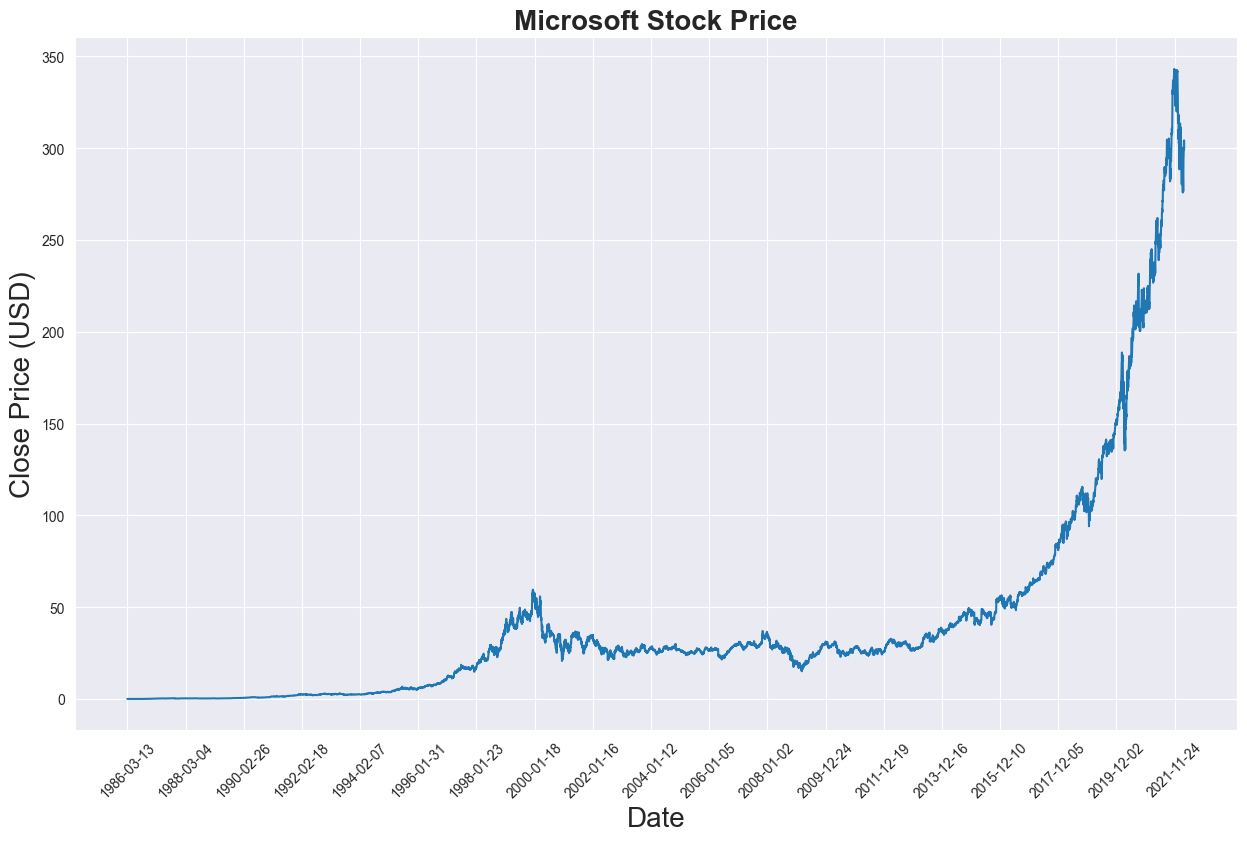

In [10]:
# We see the Close Price of the stock change with the time 
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(stocks['Close'])
plt.xticks(range(0,stocks.shape[0],500),stocks['Date'].loc[::500],rotation=45)
plt.title("Microsoft Stock Price",fontsize=20, fontweight='bold')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Close Price (USD)',fontsize=20)
plt.savefig('images/microsoft_stock_price.png')
plt.show()

## Handling Outliers

In [11]:
# Removes values that fall outside 1.5×IQR range:

Q1 = stocks['Close'].quantile(0.25)
Q3 = stocks['Close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stocks = stocks[(stocks['Close'] >= lower_bound) & (stocks['Close'] <= upper_bound)]


In [12]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8076 non-null   object 
 1   Open       8076 non-null   float64
 2   High       8076 non-null   float64
 3   Low        8076 non-null   float64
 4   Close      8076 non-null   float64
 5   Adj Close  8076 non-null   float64
 6   Volume     8076 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 504.8+ KB


## Normalizing Data

In [13]:
price = stocks[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8076 non-null   float64
dtypes: float64(1)
memory usage: 126.2 KB


In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = price.copy()
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [34]:
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


# Preparation for Model

In [15]:
# Using sliding window method 
# This creates training sampels by taking a sequence of past values and using them to predict the next values.
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0])) # 20% for testing
    train_set_size = data.shape[0] - (test_set_size) # 80% for training
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [16]:
# Transforming the data into tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Adding random seed for reproducibility
# 42 as its the Answer to the Ultimate Question of Life :D
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).to(device)

Using device: cpu


# LSTM MODEL

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :]) 
        return out

## Finding Best Parameters with HyperParameter Optimization

In [18]:
# This class will stop the training if the validation loss does not improve for a certain number of epochs (patience)
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.early_stop 


In [19]:
def train_model_optuna(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=10):
    early_stopping = EarlyStopping(patience=patience)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break
    return val_loss


def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Model
    model = LSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Data loaders
    dataset = TensorDataset(x_train, y_train_lstm)
    val_dataset = TensorDataset(x_test, y_test_lstm)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    val_loss = train_model_optuna(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=5)
    return val_loss


In [20]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=1)

print("Best trial:")
trial = study.best_trial
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2025-07-18 14:53:58,189] A new study created in memory with name: no-name-0bfde514-bf05-4f63-84b9-f8700607d9ca
Best trial: 0. Best value: 0.00182585:   0%|          | 1/200 [00:43<2:23:10, 43.17s/it]

Early stopping at epoch 21
[I 2025-07-18 14:54:41,369] Trial 0 finished with value: 0.0018258455843002035 and parameters: {'hidden_dim': 227, 'num_layers': 1, 'lr': 0.002689190710289356, 'batch_size': 64}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   1%|          | 2/200 [02:20<4:08:02, 75.17s/it]

Early stopping at epoch 28
[I 2025-07-18 14:56:18,932] Trial 1 finished with value: 0.006922522296708149 and parameters: {'hidden_dim': 173, 'num_layers': 3, 'lr': 0.00018289712141918382, 'batch_size': 128}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   2%|▏         | 3/200 [02:29<2:27:13, 44.84s/it]

Early stopping at epoch 13
[I 2025-07-18 14:56:27,687] Trial 2 finished with value: 0.007489516824045075 and parameters: {'hidden_dim': 51, 'num_layers': 1, 'lr': 0.0016741705800204538, 'batch_size': 64}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   2%|▏         | 4/200 [04:00<3:26:25, 63.19s/it]

Early stopping at epoch 79
[I 2025-07-18 14:57:59,011] Trial 3 finished with value: 0.0030650034840815064 and parameters: {'hidden_dim': 34, 'num_layers': 2, 'lr': 0.00014291367686530737, 'batch_size': 32}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   2%|▎         | 5/200 [05:26<3:51:42, 71.29s/it]

Early stopping at epoch 16
[I 2025-07-18 14:59:24,671] Trial 4 finished with value: 0.003579401056273267 and parameters: {'hidden_dim': 251, 'num_layers': 3, 'lr': 0.001334040596521701, 'batch_size': 128}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   3%|▎         | 6/200 [07:25<4:43:02, 87.54s/it]

Early stopping at epoch 34
[I 2025-07-18 15:01:23,745] Trial 5 finished with value: 0.003607187751465692 and parameters: {'hidden_dim': 171, 'num_layers': 3, 'lr': 0.00022524366391157616, 'batch_size': 128}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   4%|▎         | 7/200 [07:41<3:26:48, 64.29s/it]

Early stopping at epoch 13
[I 2025-07-18 15:01:40,176] Trial 6 finished with value: 0.005983302532023607 and parameters: {'hidden_dim': 69, 'num_layers': 2, 'lr': 0.0018679273428808107, 'batch_size': 128}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   4%|▍         | 8/200 [08:22<3:01:32, 56.73s/it]

Early stopping at epoch 12
[I 2025-07-18 15:02:20,713] Trial 7 finished with value: 0.004326359893849048 and parameters: {'hidden_dim': 240, 'num_layers': 2, 'lr': 0.003862793041336874, 'batch_size': 128}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   4%|▍         | 9/200 [10:09<3:50:37, 72.45s/it]

Early stopping at epoch 30
[I 2025-07-18 15:04:07,729] Trial 8 finished with value: 0.001856409620533948 and parameters: {'hidden_dim': 190, 'num_layers': 2, 'lr': 0.00011152561120012981, 'batch_size': 64}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 0. Best value: 0.00182585:   5%|▌         | 10/200 [10:48<3:16:47, 62.15s/it]

[I 2025-07-18 15:04:46,806] Trial 9 finished with value: 0.005776474517635786 and parameters: {'hidden_dim': 46, 'num_layers': 1, 'lr': 0.0005186911400356898, 'batch_size': 128}. Best is trial 0 with value: 0.0018258455843002035.


Best trial: 10. Best value: 0.000430115:   6%|▌         | 11/200 [11:05<2:31:46, 48.18s/it]

Early stopping at epoch 18
[I 2025-07-18 15:05:03,317] Trial 10 finished with value: 0.00043011466270679823 and parameters: {'hidden_dim': 104, 'num_layers': 1, 'lr': 0.00756967256232623, 'batch_size': 64}. Best is trial 10 with value: 0.00043011466270679823.


Best trial: 10. Best value: 0.000430115:   6%|▌         | 12/200 [11:10<1:50:00, 35.11s/it]

Early stopping at epoch 5
[I 2025-07-18 15:05:08,530] Trial 11 finished with value: 0.0019522095541245877 and parameters: {'hidden_dim': 104, 'num_layers': 1, 'lr': 0.009969146253741585, 'batch_size': 64}. Best is trial 10 with value: 0.00043011466270679823.


Best trial: 10. Best value: 0.000430115:   6%|▋         | 13/200 [11:30<1:35:24, 30.61s/it]

Early stopping at epoch 21
[I 2025-07-18 15:05:28,789] Trial 12 finished with value: 0.0018440586900396738 and parameters: {'hidden_dim': 109, 'num_layers': 1, 'lr': 0.00668660273454417, 'batch_size': 64}. Best is trial 10 with value: 0.00043011466270679823.


Best trial: 10. Best value: 0.000430115:   7%|▋         | 14/200 [11:48<1:22:46, 26.70s/it]

Early stopping at epoch 18
[I 2025-07-18 15:05:46,450] Trial 13 finished with value: 0.0008151791628803879 and parameters: {'hidden_dim': 116, 'num_layers': 1, 'lr': 0.0035761422471224016, 'batch_size': 64}. Best is trial 10 with value: 0.00043011466270679823.


Best trial: 14. Best value: 0.000307558:   8%|▊         | 15/200 [12:23<1:30:39, 29.40s/it]

Early stopping at epoch 22
[I 2025-07-18 15:06:22,117] Trial 14 finished with value: 0.0003075576488638534 and parameters: {'hidden_dim': 121, 'num_layers': 1, 'lr': 0.004571378515099152, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:   8%|▊         | 16/200 [12:55<1:32:32, 30.18s/it]

Early stopping at epoch 20
[I 2025-07-18 15:06:54,098] Trial 15 finished with value: 0.0009175882732961327 and parameters: {'hidden_dim': 135, 'num_layers': 1, 'lr': 0.0007235089704645431, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:   8%|▊         | 17/200 [13:22<1:28:21, 28.97s/it]

Early stopping at epoch 11
[I 2025-07-18 15:07:20,255] Trial 16 finished with value: 0.0018155658570535975 and parameters: {'hidden_dim': 82, 'num_layers': 2, 'lr': 0.006900533228457206, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:   9%|▉         | 18/200 [14:02<1:38:08, 32.36s/it]

Early stopping at epoch 27
[I 2025-07-18 15:08:00,497] Trial 17 finished with value: 0.00036281593223547507 and parameters: {'hidden_dim': 144, 'num_layers': 1, 'lr': 0.005313211764287081, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  10%|▉         | 19/200 [14:22<1:26:15, 28.59s/it]

Early stopping at epoch 11
[I 2025-07-18 15:08:20,322] Trial 18 finished with value: 0.0006366379802427985 and parameters: {'hidden_dim': 151, 'num_layers': 1, 'lr': 0.00439992603208078, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  10%|█         | 20/200 [16:01<2:29:48, 49.94s/it]

Early stopping at epoch 31
[I 2025-07-18 15:10:00,010] Trial 19 finished with value: 0.00044223465025139625 and parameters: {'hidden_dim': 139, 'num_layers': 2, 'lr': 0.000329181408352917, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  10%|█         | 21/200 [16:20<2:01:25, 40.70s/it]

Early stopping at epoch 9
[I 2025-07-18 15:10:19,183] Trial 20 finished with value: 0.0012890984329643805 and parameters: {'hidden_dim': 208, 'num_layers': 1, 'lr': 0.0009645248608313299, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  11%|█         | 22/200 [16:37<1:39:20, 33.49s/it]

Early stopping at epoch 13
[I 2025-07-18 15:10:35,844] Trial 21 finished with value: 0.0011400534770241483 and parameters: {'hidden_dim': 86, 'num_layers': 1, 'lr': 0.006661443941055962, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  12%|█▏        | 23/200 [16:50<1:20:52, 27.41s/it]

Early stopping at epoch 7
[I 2025-07-18 15:10:49,089] Trial 22 finished with value: 0.0016136091772019497 and parameters: {'hidden_dim': 155, 'num_layers': 1, 'lr': 0.009691417482511342, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  12%|█▏        | 24/200 [17:04<1:07:52, 23.14s/it]

Early stopping at epoch 8
[I 2025-07-18 15:11:02,253] Trial 23 finished with value: 0.0007919541099445447 and parameters: {'hidden_dim': 121, 'num_layers': 1, 'lr': 0.002540606258533268, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  12%|█▎        | 25/200 [17:31<1:11:24, 24.48s/it]

Early stopping at epoch 20
[I 2025-07-18 15:11:29,880] Trial 24 finished with value: 0.00046608455601267006 and parameters: {'hidden_dim': 93, 'num_layers': 1, 'lr': 0.004813334856840652, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  13%|█▎        | 26/200 [17:52<1:07:59, 23.44s/it]

Early stopping at epoch 10
[I 2025-07-18 15:11:50,894] Trial 25 finished with value: 0.0020466970983341946 and parameters: {'hidden_dim': 126, 'num_layers': 2, 'lr': 0.0025201013164014557, 'batch_size': 64}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  14%|█▎        | 27/200 [18:21<1:12:05, 25.00s/it]

Early stopping at epoch 16
[I 2025-07-18 15:12:19,530] Trial 26 finished with value: 0.0006233120679383979 and parameters: {'hidden_dim': 164, 'num_layers': 1, 'lr': 0.005478457137552145, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  14%|█▍        | 28/200 [18:41<1:07:26, 23.53s/it]

Early stopping at epoch 11
[I 2025-07-18 15:12:39,621] Trial 27 finished with value: 0.0015991755171853583 and parameters: {'hidden_dim': 195, 'num_layers': 1, 'lr': 0.0033795702928367966, 'batch_size': 64}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  14%|█▍        | 29/200 [19:38<1:35:46, 33.61s/it]

Early stopping at epoch 26
[I 2025-07-18 15:13:36,738] Trial 28 finished with value: 0.005517297537367353 and parameters: {'hidden_dim': 70, 'num_layers': 2, 'lr': 0.008435983586297694, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  15%|█▌        | 30/200 [19:51<1:17:35, 27.39s/it]

Early stopping at epoch 15
[I 2025-07-18 15:13:49,615] Trial 29 finished with value: 0.0010300667960948956 and parameters: {'hidden_dim': 100, 'num_layers': 1, 'lr': 0.002087807019448751, 'batch_size': 64}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  16%|█▌        | 31/200 [20:08<1:08:04, 24.17s/it]

Early stopping at epoch 10
[I 2025-07-18 15:14:06,275] Trial 30 finished with value: 0.0007968673279381119 and parameters: {'hidden_dim': 135, 'num_layers': 1, 'lr': 0.005480367064672699, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  16%|█▌        | 32/200 [21:02<1:33:06, 33.26s/it]

Early stopping at epoch 11
[I 2025-07-18 15:15:00,733] Trial 31 finished with value: 0.0027084247195293134 and parameters: {'hidden_dim': 135, 'num_layers': 3, 'lr': 0.00043794826768269433, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  16%|█▋        | 33/200 [22:12<2:02:47, 44.12s/it]

Early stopping at epoch 22
[I 2025-07-18 15:16:10,202] Trial 32 finished with value: 0.0004159469358188182 and parameters: {'hidden_dim': 138, 'num_layers': 2, 'lr': 0.0012079653986770376, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  17%|█▋        | 34/200 [23:16<2:18:59, 50.24s/it]

Early stopping at epoch 12
[I 2025-07-18 15:17:14,715] Trial 33 finished with value: 0.007191188790945008 and parameters: {'hidden_dim': 153, 'num_layers': 3, 'lr': 0.003119787864067174, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  18%|█▊        | 35/200 [23:42<1:57:47, 42.83s/it]

Early stopping at epoch 6
[I 2025-07-18 15:17:40,272] Trial 34 finished with value: 0.0023204993355880016 and parameters: {'hidden_dim': 182, 'num_layers': 2, 'lr': 0.000972042835923616, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  18%|█▊        | 36/200 [23:58<1:35:36, 34.98s/it]

Early stopping at epoch 16
[I 2025-07-18 15:17:56,918] Trial 35 finished with value: 0.0005795232749593337 and parameters: {'hidden_dim': 121, 'num_layers': 1, 'lr': 0.0013373131334174313, 'batch_size': 64}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  18%|█▊        | 37/200 [25:15<2:09:15, 47.58s/it]

Early stopping at epoch 20
[I 2025-07-18 15:19:13,900] Trial 36 finished with value: 0.006258780416044151 and parameters: {'hidden_dim': 169, 'num_layers': 2, 'lr': 0.007415404700680051, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  19%|█▉        | 38/200 [26:10<2:14:03, 49.65s/it]

Early stopping at epoch 16
[I 2025-07-18 15:20:08,389] Trial 37 finished with value: 0.0028793039271156028 and parameters: {'hidden_dim': 71, 'num_layers': 3, 'lr': 0.0054059624204894005, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  20%|█▉        | 39/200 [26:32<1:51:30, 41.55s/it]

Early stopping at epoch 7
[I 2025-07-18 15:20:31,047] Trial 38 finished with value: 0.002117958886978718 and parameters: {'hidden_dim': 209, 'num_layers': 2, 'lr': 0.001531338281763592, 'batch_size': 128}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  20%|██        | 40/200 [26:58<1:37:55, 36.72s/it]

Early stopping at epoch 17
[I 2025-07-18 15:20:56,501] Trial 39 finished with value: 0.0006080824890747094 and parameters: {'hidden_dim': 146, 'num_layers': 1, 'lr': 0.0024436331578096934, 'batch_size': 64}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  20%|██        | 41/200 [27:35<1:37:58, 36.97s/it]

Early stopping at epoch 44
[I 2025-07-18 15:21:34,057] Trial 40 finished with value: 0.004600419577820083 and parameters: {'hidden_dim': 111, 'num_layers': 1, 'lr': 0.0001972910250296383, 'batch_size': 128}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  21%|██        | 42/200 [28:10<1:35:10, 36.14s/it]

Early stopping at epoch 10
[I 2025-07-18 15:22:08,253] Trial 41 finished with value: 0.002296765772745643 and parameters: {'hidden_dim': 132, 'num_layers': 2, 'lr': 0.0005472883460573779, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 14. Best value: 0.000307558:  22%|██▏       | 43/200 [29:14<1:56:56, 44.69s/it]

Early stopping at epoch 19
[I 2025-07-18 15:23:12,891] Trial 42 finished with value: 0.0012908106964816541 and parameters: {'hidden_dim': 142, 'num_layers': 2, 'lr': 0.0003393383969116652, 'batch_size': 32}. Best is trial 14 with value: 0.0003075576488638534.


Best trial: 43. Best value: 0.00028309:  22%|██▏       | 44/200 [34:45<5:39:17, 130.50s/it]

Early stopping at epoch 47
[I 2025-07-18 15:28:43,604] Trial 43 finished with value: 0.0002830899949699147 and parameters: {'hidden_dim': 163, 'num_layers': 2, 'lr': 0.000280338179658597, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  22%|██▎       | 45/200 [41:06<8:51:05, 205.58s/it]

Early stopping at epoch 16
[I 2025-07-18 15:35:04,394] Trial 44 finished with value: 0.0010803790464706253 and parameters: {'hidden_dim': 163, 'num_layers': 2, 'lr': 0.00012255184152796034, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  23%|██▎       | 46/200 [1:56:48<64:27:01, 1506.63s/it]

Early stopping at epoch 15
[I 2025-07-18 16:50:46,807] Trial 45 finished with value: 0.005508912119974132 and parameters: {'hidden_dim': 183, 'num_layers': 3, 'lr': 0.000251066615179988, 'batch_size': 64}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  24%|██▎       | 47/200 [1:57:25<45:17:22, 1065.64s/it]

Early stopping at epoch 13
[I 2025-07-18 16:51:23,463] Trial 46 finished with value: 0.0012703012402840506 and parameters: {'hidden_dim': 101, 'num_layers': 2, 'lr': 0.0007692109347950864, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  24%|██▍       | 48/200 [1:57:52<31:50:20, 754.08s/it] 

Early stopping at epoch 15
[I 2025-07-18 16:51:50,571] Trial 47 finished with value: 0.0030529562634630846 and parameters: {'hidden_dim': 125, 'num_layers': 2, 'lr': 0.004115855314249981, 'batch_size': 128}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  24%|██▍       | 49/200 [1:58:56<22:56:46, 547.06s/it]

Early stopping at epoch 56
[I 2025-07-18 16:52:54,587] Trial 48 finished with value: 0.0025377697367694766 and parameters: {'hidden_dim': 56, 'num_layers': 1, 'lr': 0.00015228135745863814, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  25%|██▌       | 50/200 [2:02:51<18:53:48, 453.53s/it]

Early stopping at epoch 9
[I 2025-07-18 16:56:49,861] Trial 49 finished with value: 0.001355060489004245 and parameters: {'hidden_dim': 113, 'num_layers': 1, 'lr': 0.0018721276210139383, 'batch_size': 64}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  26%|██▌       | 51/200 [2:05:34<15:09:59, 366.44s/it]

Early stopping at epoch 26
[I 2025-07-18 16:59:33,111] Trial 50 finished with value: 0.01577857231399428 and parameters: {'hidden_dim': 155, 'num_layers': 3, 'lr': 0.007796722875656917, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  26%|██▌       | 52/200 [2:05:59<10:51:07, 263.97s/it]

Early stopping at epoch 7
[I 2025-07-18 16:59:57,976] Trial 51 finished with value: 0.0026651011870069173 and parameters: {'hidden_dim': 144, 'num_layers': 2, 'lr': 0.000248263650540213, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  26%|██▋       | 53/200 [2:08:25<9:19:40, 228.44s/it] 

Early stopping at epoch 41
[I 2025-07-18 17:02:23,521] Trial 52 finished with value: 0.0003154801064845421 and parameters: {'hidden_dim': 176, 'num_layers': 2, 'lr': 0.00034484138809250494, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  27%|██▋       | 54/200 [2:08:55<6:51:10, 168.97s/it]

Early stopping at epoch 7
[I 2025-07-18 17:02:53,736] Trial 53 finished with value: 0.0029400696632151 and parameters: {'hidden_dim': 177, 'num_layers': 2, 'lr': 0.0003102163301430639, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  28%|██▊       | 55/200 [2:09:31<5:11:44, 129.00s/it]

Early stopping at epoch 9
[I 2025-07-18 17:03:29,454] Trial 54 finished with value: 0.0011569791177844665 and parameters: {'hidden_dim': 165, 'num_layers': 2, 'lr': 0.00043873155361650836, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  28%|██▊       | 56/200 [2:09:54<3:53:40, 97.36s/it] 

Early stopping at epoch 5
[I 2025-07-18 17:03:53,001] Trial 55 finished with value: 0.002508004486741151 and parameters: {'hidden_dim': 191, 'num_layers': 2, 'lr': 0.0006953303256176907, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  28%|██▊       | 57/200 [2:10:15<2:57:08, 74.32s/it]

Early stopping at epoch 8
[I 2025-07-18 17:04:13,567] Trial 56 finished with value: 0.0007736102681305698 and parameters: {'hidden_dim': 227, 'num_layers': 1, 'lr': 0.001151879624847648, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  29%|██▉       | 58/200 [2:11:17<2:46:56, 70.54s/it]

Early stopping at epoch 88
[I 2025-07-18 17:05:15,274] Trial 57 finished with value: 0.005919916671700776 and parameters: {'hidden_dim': 92, 'num_layers': 1, 'lr': 0.00017511290496552957, 'batch_size': 128}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  30%|██▉       | 59/200 [2:12:30<2:47:39, 71.35s/it]

Early stopping at epoch 17
[I 2025-07-18 17:06:28,507] Trial 58 finished with value: 0.00039476828133760424 and parameters: {'hidden_dim': 199, 'num_layers': 2, 'lr': 0.0029934193980395226, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  30%|███       | 60/200 [2:13:52<2:53:57, 74.55s/it]

Early stopping at epoch 19
[I 2025-07-18 17:07:50,537] Trial 59 finished with value: 0.0014694109852950764 and parameters: {'hidden_dim': 198, 'num_layers': 2, 'lr': 0.005950150037639118, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  30%|███       | 61/200 [2:17:32<4:33:53, 118.23s/it]

Early stopping at epoch 20
[I 2025-07-18 17:11:30,681] Trial 60 finished with value: 0.0021794176477580515 and parameters: {'hidden_dim': 228, 'num_layers': 2, 'lr': 0.0030179376173528156, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  31%|███       | 62/200 [2:18:26<3:47:29, 98.91s/it] 

Early stopping at epoch 11
[I 2025-07-18 17:12:24,513] Trial 61 finished with value: 0.0028528813255594716 and parameters: {'hidden_dim': 209, 'num_layers': 2, 'lr': 0.0044560831614351565, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  32%|███▏      | 63/200 [2:19:19<3:14:24, 85.14s/it]

Early stopping at epoch 13
[I 2025-07-18 17:13:17,523] Trial 62 finished with value: 0.002841587873120386 and parameters: {'hidden_dim': 175, 'num_layers': 2, 'lr': 0.00385464486422563, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  32%|███▏      | 64/200 [2:19:39<2:28:57, 65.72s/it]

Early stopping at epoch 5
[I 2025-07-18 17:13:37,928] Trial 63 finished with value: 0.07239555380342957 and parameters: {'hidden_dim': 161, 'num_layers': 2, 'lr': 0.008473164648563786, 'batch_size': 64}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  32%|███▎      | 65/200 [2:20:00<1:57:46, 52.35s/it]

Early stopping at epoch 9
[I 2025-07-18 17:13:59,073] Trial 64 finished with value: 0.0004123873899088186 and parameters: {'hidden_dim': 200, 'num_layers': 1, 'lr': 0.00584125236027063, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  33%|███▎      | 66/200 [2:21:56<2:39:29, 71.41s/it]

Early stopping at epoch 24
[I 2025-07-18 17:15:54,973] Trial 65 finished with value: 0.0007415558634152951 and parameters: {'hidden_dim': 219, 'num_layers': 2, 'lr': 0.004814473096657319, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  34%|███▎      | 67/200 [2:22:12<2:01:15, 54.70s/it]

Early stopping at epoch 7
[I 2025-07-18 17:16:10,685] Trial 66 finished with value: 0.002089805379178941 and parameters: {'hidden_dim': 184, 'num_layers': 1, 'lr': 0.0021592936977895038, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  34%|███▍      | 68/200 [2:23:14<2:05:10, 56.89s/it]

Early stopping at epoch 13
[I 2025-07-18 17:17:12,693] Trial 67 finished with value: 0.001972588966286732 and parameters: {'hidden_dim': 205, 'num_layers': 2, 'lr': 0.00612182230649891, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  34%|███▍      | 69/200 [2:23:44<1:46:19, 48.70s/it]

Early stopping at epoch 11
[I 2025-07-18 17:17:42,256] Trial 68 finished with value: 0.0004820529859131841 and parameters: {'hidden_dim': 245, 'num_layers': 1, 'lr': 0.0029621014372746106, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  35%|███▌      | 70/200 [2:25:23<2:18:14, 63.80s/it]

Early stopping at epoch 12
[I 2025-07-18 17:19:21,318] Trial 69 finished with value: 0.0013936300547000284 and parameters: {'hidden_dim': 200, 'num_layers': 2, 'lr': 0.003486048430536859, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  36%|███▌      | 71/200 [2:25:43<1:49:09, 50.77s/it]

Early stopping at epoch 7
[I 2025-07-18 17:19:41,667] Trial 70 finished with value: 0.0010368209853671335 and parameters: {'hidden_dim': 221, 'num_layers': 1, 'lr': 0.0008362178237973114, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  36%|███▌      | 72/200 [2:26:25<1:42:30, 48.05s/it]

Early stopping at epoch 29
[I 2025-07-18 17:20:23,382] Trial 71 finished with value: 0.0009502325493275959 and parameters: {'hidden_dim': 129, 'num_layers': 1, 'lr': 0.009294399502169105, 'batch_size': 64}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  36%|███▋      | 73/200 [2:26:44<1:23:27, 39.43s/it]

Early stopping at epoch 11
[I 2025-07-18 17:20:42,685] Trial 72 finished with value: 0.00048504179768297395 and parameters: {'hidden_dim': 118, 'num_layers': 1, 'lr': 0.006654768935922494, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  37%|███▋      | 74/200 [2:27:10<1:14:39, 35.55s/it]

Early stopping at epoch 17
[I 2025-07-18 17:21:09,192] Trial 73 finished with value: 0.0003456806110383089 and parameters: {'hidden_dim': 107, 'num_layers': 1, 'lr': 0.004688896489658224, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  38%|███▊      | 75/200 [2:28:25<1:38:15, 47.17s/it]

Early stopping at epoch 42
[I 2025-07-18 17:22:23,462] Trial 74 finished with value: 0.000689439486307617 and parameters: {'hidden_dim': 147, 'num_layers': 1, 'lr': 0.00540738047272967, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  38%|███▊      | 76/200 [2:29:32<1:50:00, 53.23s/it]

Early stopping at epoch 32
[I 2025-07-18 17:23:30,834] Trial 75 finished with value: 0.00043638297018547105 and parameters: {'hidden_dim': 189, 'num_layers': 1, 'lr': 0.004520994565949836, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  38%|███▊      | 77/200 [2:29:54<1:29:57, 43.88s/it]

Early stopping at epoch 10
[I 2025-07-18 17:23:52,906] Trial 76 finished with value: 0.0010441808471845363 and parameters: {'hidden_dim': 158, 'num_layers': 1, 'lr': 0.0005825608335425927, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  39%|███▉      | 78/200 [2:30:34<1:26:47, 42.68s/it]

Early stopping at epoch 22
[I 2025-07-18 17:24:32,784] Trial 77 finished with value: 0.001235195843679214 and parameters: {'hidden_dim': 138, 'num_layers': 1, 'lr': 0.0003984358252198551, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  40%|███▉      | 79/200 [2:31:41<1:40:36, 49.89s/it]

Early stopping at epoch 16
[I 2025-07-18 17:25:39,486] Trial 78 finished with value: 0.0008501093372401289 and parameters: {'hidden_dim': 167, 'num_layers': 2, 'lr': 0.0038570816984942287, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  40%|████      | 80/200 [2:32:26<1:36:55, 48.47s/it]

Early stopping at epoch 23
[I 2025-07-18 17:26:24,635] Trial 79 finished with value: 0.00032906002632123143 and parameters: {'hidden_dim': 172, 'num_layers': 1, 'lr': 0.0033616862463126695, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  40%|████      | 81/200 [2:32:42<1:16:38, 38.64s/it]

Early stopping at epoch 7
[I 2025-07-18 17:26:40,353] Trial 80 finished with value: 0.0017798579408953824 and parameters: {'hidden_dim': 180, 'num_layers': 1, 'lr': 0.0027590141097393194, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  41%|████      | 82/200 [2:33:10<1:09:42, 35.45s/it]

Early stopping at epoch 13
[I 2025-07-18 17:27:08,347] Trial 81 finished with value: 0.0005842360965199951 and parameters: {'hidden_dim': 172, 'num_layers': 1, 'lr': 0.004804293686368494, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  42%|████▏     | 83/200 [2:33:35<1:03:18, 32.46s/it]

Early stopping at epoch 14
[I 2025-07-18 17:27:33,849] Trial 82 finished with value: 0.00043802045476303307 and parameters: {'hidden_dim': 150, 'num_layers': 1, 'lr': 0.003402956650960716, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  42%|████▏     | 84/200 [2:34:11<1:04:33, 33.39s/it]

Early stopping at epoch 24
[I 2025-07-18 17:28:09,406] Trial 83 finished with value: 0.0003991907952677495 and parameters: {'hidden_dim': 105, 'num_layers': 1, 'lr': 0.0015759327433545601, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  42%|████▎     | 85/200 [2:34:21<50:29, 26.35s/it]  

Early stopping at epoch 6
[I 2025-07-18 17:28:19,317] Trial 84 finished with value: 0.0011168530587633094 and parameters: {'hidden_dim': 106, 'num_layers': 1, 'lr': 0.0022076035780616834, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  43%|████▎     | 86/200 [2:34:36<43:59, 23.15s/it]

Early stopping at epoch 24
[I 2025-07-18 17:28:35,004] Trial 85 finished with value: 0.00308210207731463 and parameters: {'hidden_dim': 78, 'num_layers': 1, 'lr': 0.0014305161792003943, 'batch_size': 128}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  44%|████▎     | 87/200 [2:35:05<46:47, 24.85s/it]

Early stopping at epoch 18
[I 2025-07-18 17:29:03,813] Trial 86 finished with value: 0.0005850070589861157 and parameters: {'hidden_dim': 95, 'num_layers': 1, 'lr': 0.0019321406139955154, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  44%|████▍     | 88/200 [2:35:36<49:53, 26.72s/it]

Early stopping at epoch 14
[I 2025-07-18 17:29:34,914] Trial 87 finished with value: 0.0003870199259693561 and parameters: {'hidden_dim': 188, 'num_layers': 1, 'lr': 0.006217765426202797, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  44%|████▍     | 89/200 [2:36:04<50:11, 27.13s/it]

Early stopping at epoch 14
[I 2025-07-18 17:30:02,995] Trial 88 finished with value: 0.0006453295139305969 and parameters: {'hidden_dim': 172, 'num_layers': 1, 'lr': 0.005011583678398865, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  45%|████▌     | 90/200 [2:36:55<1:02:38, 34.17s/it]

Early stopping at epoch 25
[I 2025-07-18 17:30:53,595] Trial 89 finished with value: 0.0005794862325488151 and parameters: {'hidden_dim': 188, 'num_layers': 1, 'lr': 0.007196747966615016, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  46%|████▌     | 91/200 [2:37:04<48:37, 26.77s/it]  

Early stopping at epoch 5
[I 2025-07-18 17:31:03,082] Trial 90 finished with value: 0.0017723002404048149 and parameters: {'hidden_dim': 124, 'num_layers': 1, 'lr': 0.003916367567885755, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  46%|████▌     | 92/200 [2:37:27<46:02, 25.58s/it]

Early stopping at epoch 10
[I 2025-07-18 17:31:25,880] Trial 91 finished with value: 0.00036949028050431106 and parameters: {'hidden_dim': 197, 'num_layers': 1, 'lr': 0.005871042784919761, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  46%|████▋     | 93/200 [2:39:20<1:32:06, 51.65s/it]

Early stopping at epoch 19
[I 2025-07-18 17:33:18,361] Trial 92 finished with value: 0.00035542468964087996 and parameters: {'hidden_dim': 115, 'num_layers': 1, 'lr': 0.006380071395363464, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  47%|████▋     | 94/200 [2:39:41<1:15:10, 42.56s/it]

Early stopping at epoch 9
[I 2025-07-18 17:33:39,703] Trial 93 finished with value: 0.0007748378314621126 and parameters: {'hidden_dim': 193, 'num_layers': 1, 'lr': 0.006552679659813924, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  48%|████▊     | 95/200 [2:40:04<1:04:14, 36.71s/it]

Early stopping at epoch 11
[I 2025-07-18 17:34:02,760] Trial 94 finished with value: 0.0019522595988853615 and parameters: {'hidden_dim': 178, 'num_layers': 1, 'lr': 0.00027915837247522867, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  48%|████▊     | 96/200 [2:40:43<1:04:31, 37.23s/it]

Early stopping at epoch 27
[I 2025-07-18 17:34:41,213] Trial 95 finished with value: 0.0006038403620657525 and parameters: {'hidden_dim': 112, 'num_layers': 1, 'lr': 0.00855988089172495, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  48%|████▊     | 97/200 [2:41:18<1:02:46, 36.57s/it]

Early stopping at epoch 17
[I 2025-07-18 17:35:16,230] Trial 96 finished with value: 0.00031397790221757637 and parameters: {'hidden_dim': 185, 'num_layers': 1, 'lr': 0.007872960185258848, 'batch_size': 32}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 43. Best value: 0.00028309:  49%|████▉     | 98/200 [2:41:41<55:19, 32.55s/it]  

Early stopping at epoch 20
[I 2025-07-18 17:35:39,396] Trial 97 finished with value: 0.0030766887402233598 and parameters: {'hidden_dim': 184, 'num_layers': 1, 'lr': 0.00994617505057445, 'batch_size': 128}. Best is trial 43 with value: 0.0002830899949699147.


Best trial: 98. Best value: 0.000278488:  50%|████▉     | 99/200 [2:45:36<2:37:16, 93.43s/it]

Early stopping at epoch 25
[I 2025-07-18 17:39:34,895] Trial 98 finished with value: 0.00027848781168109317 and parameters: {'hidden_dim': 161, 'num_layers': 1, 'lr': 0.0077606316191056735, 'batch_size': 32}. Best is trial 98 with value: 0.00027848781168109317.


Best trial: 98. Best value: 0.000278488:  50%|█████     | 100/200 [2:56:35<7:18:18, 262.98s/it]

Early stopping at epoch 14
[I 2025-07-18 17:50:33,487] Trial 99 finished with value: 0.0009007072733890941 and parameters: {'hidden_dim': 158, 'num_layers': 1, 'lr': 0.00020327491239413177, 'batch_size': 32}. Best is trial 98 with value: 0.00027848781168109317.


Best trial: 100. Best value: 0.000242944:  50%|█████     | 101/200 [3:07:52<10:39:08, 387.36s/it]

Early stopping at epoch 24
[I 2025-07-18 18:01:51,075] Trial 100 finished with value: 0.00024294433737226178 and parameters: {'hidden_dim': 170, 'num_layers': 1, 'lr': 0.007949717791367461, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  51%|█████     | 102/200 [3:23:26<15:00:30, 551.33s/it]

Early stopping at epoch 24
[I 2025-07-18 18:17:25,011] Trial 101 finished with value: 0.00025302425124477045 and parameters: {'hidden_dim': 166, 'num_layers': 1, 'lr': 0.00779079167497227, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  52%|█████▏    | 103/200 [3:30:48<13:58:22, 518.58s/it]

Early stopping at epoch 9
[I 2025-07-18 18:24:47,158] Trial 102 finished with value: 0.001199949915947703 and parameters: {'hidden_dim': 167, 'num_layers': 1, 'lr': 0.00803262013598328, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  52%|█████▏    | 104/200 [3:57:06<22:17:54, 836.20s/it]

Early stopping at epoch 20
[I 2025-07-18 18:51:04,466] Trial 103 finished with value: 0.0003743615542428897 and parameters: {'hidden_dim': 159, 'num_layers': 1, 'lr': 0.00716013833364557, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  52%|█████▎    | 105/200 [4:36:40<34:14:25, 1297.53s/it]

Early stopping at epoch 19
[I 2025-07-18 19:30:38,437] Trial 104 finished with value: 0.0011845828289640886 and parameters: {'hidden_dim': 150, 'num_layers': 1, 'lr': 0.008990543942340732, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  53%|█████▎    | 106/200 [4:51:15<30:34:28, 1170.94s/it]

Early stopping at epoch 15
[I 2025-07-18 19:45:13,993] Trial 105 finished with value: 0.0004854748195594213 and parameters: {'hidden_dim': 171, 'num_layers': 1, 'lr': 0.007453504788678381, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  54%|█████▎    | 107/200 [5:04:59<27:33:28, 1066.75s/it]

Early stopping at epoch 31
[I 2025-07-18 19:58:57,649] Trial 106 finished with value: 0.00027426797140494685 and parameters: {'hidden_dim': 164, 'num_layers': 1, 'lr': 0.005320895658088728, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  54%|█████▍    | 108/200 [5:16:20<24:18:04, 950.92s/it] 

Early stopping at epoch 22
[I 2025-07-18 20:10:18,299] Trial 107 finished with value: 0.0010250734690891799 and parameters: {'hidden_dim': 175, 'num_layers': 1, 'lr': 0.008133150032803524, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  55%|█████▍    | 109/200 [5:20:33<18:44:53, 741.69s/it]

Early stopping at epoch 14
[I 2025-07-18 20:14:31,788] Trial 108 finished with value: 0.0009427770553384998 and parameters: {'hidden_dim': 162, 'num_layers': 1, 'lr': 0.0067657655938145, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  55%|█████▌    | 110/200 [5:25:44<15:18:39, 612.44s/it]

Early stopping at epoch 15
[I 2025-07-18 20:19:42,654] Trial 109 finished with value: 0.0012585678755296576 and parameters: {'hidden_dim': 155, 'num_layers': 1, 'lr': 0.00420314329367178, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  56%|█████▌    | 111/200 [5:30:34<12:44:47, 515.59s/it]

Early stopping at epoch 23
[I 2025-07-18 20:24:32,245] Trial 110 finished with value: 0.0005574929549338241 and parameters: {'hidden_dim': 168, 'num_layers': 1, 'lr': 0.005252252732014005, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  56%|█████▌    | 112/200 [5:47:04<16:05:16, 658.14s/it]

Early stopping at epoch 21
[I 2025-07-18 20:41:03,013] Trial 111 finished with value: 0.0007004691219395574 and parameters: {'hidden_dim': 141, 'num_layers': 1, 'lr': 0.005687670360679625, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  56%|█████▋    | 113/200 [5:56:55<15:24:49, 637.81s/it]

Early stopping at epoch 10
[I 2025-07-18 20:50:53,384] Trial 112 finished with value: 0.000618122123734222 and parameters: {'hidden_dim': 116, 'num_layers': 1, 'lr': 0.006382851528410315, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  57%|█████▋    | 114/200 [5:57:28<10:54:25, 456.57s/it]

Early stopping at epoch 19
[I 2025-07-18 20:51:27,075] Trial 113 finished with value: 0.00043454450311472494 and parameters: {'hidden_dim': 131, 'num_layers': 1, 'lr': 0.004817492393298512, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  57%|█████▊    | 115/200 [5:57:57<7:45:05, 328.30s/it] 

Early stopping at epoch 13
[I 2025-07-18 20:51:56,075] Trial 114 finished with value: 0.001102743396782613 and parameters: {'hidden_dim': 179, 'num_layers': 1, 'lr': 0.00037249045650920496, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  58%|█████▊    | 116/200 [5:58:25<5:33:14, 238.03s/it]

Early stopping at epoch 14
[I 2025-07-18 20:52:23,468] Trial 115 finished with value: 0.0009239960707810835 and parameters: {'hidden_dim': 164, 'num_layers': 1, 'lr': 0.007518495454856264, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  58%|█████▊    | 117/200 [5:59:37<4:20:33, 188.35s/it]

Early stopping at epoch 13
[I 2025-07-18 20:53:35,914] Trial 116 finished with value: 0.002009907964498316 and parameters: {'hidden_dim': 154, 'num_layers': 3, 'lr': 0.008990927066752818, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  59%|█████▉    | 118/200 [5:59:48<3:04:46, 135.20s/it]

Early stopping at epoch 10
[I 2025-07-18 20:53:47,081] Trial 117 finished with value: 0.0008322755815103077 and parameters: {'hidden_dim': 145, 'num_layers': 1, 'lr': 0.0045523929426780465, 'batch_size': 128}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  60%|█████▉    | 119/200 [6:00:02<2:13:24, 98.82s/it] 

Early stopping at epoch 8
[I 2025-07-18 20:54:01,025] Trial 118 finished with value: 0.004241038774375292 and parameters: {'hidden_dim': 120, 'num_layers': 1, 'lr': 0.006948333947587532, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  60%|██████    | 120/200 [6:00:35<1:45:11, 78.90s/it]

Early stopping at epoch 14
[I 2025-07-18 20:54:33,426] Trial 119 finished with value: 0.0005343770291587777 and parameters: {'hidden_dim': 173, 'num_layers': 1, 'lr': 0.005349683964355568, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  60%|██████    | 121/200 [6:01:01<1:23:10, 63.18s/it]

Early stopping at epoch 12
[I 2025-07-18 20:54:59,920] Trial 120 finished with value: 0.00048039895373935284 and parameters: {'hidden_dim': 185, 'num_layers': 1, 'lr': 0.007751020670801208, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  61%|██████    | 122/200 [6:01:41<1:13:07, 56.26s/it]

Early stopping at epoch 26
[I 2025-07-18 20:55:40,028] Trial 121 finished with value: 0.000608258561317366 and parameters: {'hidden_dim': 99, 'num_layers': 1, 'lr': 0.006227364093260942, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  62%|██████▏   | 123/200 [6:02:42<1:13:58, 57.65s/it]

Early stopping at epoch 30
[I 2025-07-18 20:56:40,923] Trial 122 finished with value: 0.0004809010449617727 and parameters: {'hidden_dim': 177, 'num_layers': 1, 'lr': 0.005950447601981239, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  62%|██████▏   | 124/200 [6:04:01<1:21:07, 64.04s/it]

Early stopping at epoch 34
[I 2025-07-18 20:57:59,886] Trial 123 finished with value: 0.0005349942681884082 and parameters: {'hidden_dim': 195, 'num_layers': 1, 'lr': 0.00567892337988455, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  62%|██████▎   | 125/200 [6:04:26<1:05:10, 52.14s/it]

Early stopping at epoch 11
[I 2025-07-18 20:58:24,251] Trial 124 finished with value: 0.001048914300661315 and parameters: {'hidden_dim': 169, 'num_layers': 1, 'lr': 0.005196549193719392, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  63%|██████▎   | 126/200 [6:04:38<49:40, 40.28s/it]  

Early stopping at epoch 20
[I 2025-07-18 20:58:36,870] Trial 125 finished with value: 0.0002829750170777141 and parameters: {'hidden_dim': 36, 'num_layers': 1, 'lr': 0.00994576261439881, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  64%|██████▎   | 127/200 [6:05:33<54:15, 44.59s/it]

[I 2025-07-18 20:59:31,517] Trial 126 finished with value: 0.0023627782567714082 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'lr': 0.00010117028357691418, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  64%|██████▍   | 128/200 [6:05:43<41:00, 34.17s/it]

Early stopping at epoch 13
[I 2025-07-18 20:59:41,362] Trial 127 finished with value: 0.0003805450278199643 and parameters: {'hidden_dim': 52, 'num_layers': 1, 'lr': 0.00926804911558519, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  64%|██████▍   | 129/200 [6:06:17<40:38, 34.34s/it]

Early stopping at epoch 25
[I 2025-07-18 21:00:16,111] Trial 128 finished with value: 0.0006145809582484813 and parameters: {'hidden_dim': 89, 'num_layers': 1, 'lr': 0.008171513894845982, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  65%|██████▌   | 130/200 [6:07:04<44:25, 38.08s/it]

Early stopping at epoch 21
[I 2025-07-18 21:01:02,927] Trial 129 finished with value: 0.010967574544058433 and parameters: {'hidden_dim': 76, 'num_layers': 3, 'lr': 0.009659523385445195, 'batch_size': 64}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  66%|██████▌   | 131/200 [6:07:30<39:31, 34.37s/it]

Early stopping at epoch 14
[I 2025-07-18 21:01:28,635] Trial 130 finished with value: 0.0007607260710096406 and parameters: {'hidden_dim': 148, 'num_layers': 1, 'lr': 0.008584904338389066, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  66%|██████▌   | 132/200 [6:08:03<38:31, 33.99s/it]

Early stopping at epoch 13
[I 2025-07-18 21:02:01,729] Trial 131 finished with value: 0.002117757981442778 and parameters: {'hidden_dim': 204, 'num_layers': 1, 'lr': 0.0002959865470664727, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  66%|██████▋   | 133/200 [6:08:20<32:19, 28.95s/it]

Early stopping at epoch 8
[I 2025-07-18 21:02:18,928] Trial 132 finished with value: 0.0009330881019231325 and parameters: {'hidden_dim': 164, 'num_layers': 1, 'lr': 0.006760476077651395, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  67%|██████▋   | 134/200 [6:09:00<35:18, 32.10s/it]

Early stopping at epoch 59
[I 2025-07-18 21:02:58,362] Trial 133 finished with value: 0.0014576259781475243 and parameters: {'hidden_dim': 41, 'num_layers': 1, 'lr': 0.00023900778736256426, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  68%|██████▊   | 135/200 [6:09:15<29:16, 27.02s/it]

Early stopping at epoch 7
[I 2025-07-18 21:03:13,538] Trial 134 finished with value: 0.0013074096065133298 and parameters: {'hidden_dim': 159, 'num_layers': 1, 'lr': 0.004210001336197866, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  68%|██████▊   | 136/200 [6:10:34<45:39, 42.80s/it]

Early stopping at epoch 32
[I 2025-07-18 21:04:33,168] Trial 135 finished with value: 0.0005061224961251605 and parameters: {'hidden_dim': 214, 'num_layers': 1, 'lr': 0.0037109814436660257, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  68%|██████▊   | 137/200 [6:10:50<36:25, 34.68s/it]

Early stopping at epoch 19
[I 2025-07-18 21:04:48,906] Trial 136 finished with value: 0.0004078588804701462 and parameters: {'hidden_dim': 59, 'num_layers': 1, 'lr': 0.0074205873171414565, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  69%|██████▉   | 138/200 [6:11:13<32:05, 31.05s/it]

Early stopping at epoch 10
[I 2025-07-18 21:05:11,485] Trial 137 finished with value: 0.000845789976201737 and parameters: {'hidden_dim': 180, 'num_layers': 1, 'lr': 0.00992935404000747, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  70%|██████▉   | 139/200 [6:11:50<33:27, 32.92s/it]

Early stopping at epoch 21
[I 2025-07-18 21:05:48,749] Trial 138 finished with value: 0.0008207041736408 and parameters: {'hidden_dim': 135, 'num_layers': 1, 'lr': 0.005960961537651828, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  70%|███████   | 140/200 [6:12:35<36:29, 36.49s/it]

Early stopping at epoch 22
[I 2025-07-18 21:06:33,589] Trial 139 finished with value: 0.00038473173416979774 and parameters: {'hidden_dim': 173, 'num_layers': 1, 'lr': 0.004768725364082585, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  70%|███████   | 141/200 [6:12:47<28:33, 29.03s/it]

Early stopping at epoch 9
[I 2025-07-18 21:06:45,220] Trial 140 finished with value: 0.009073231675406883 and parameters: {'hidden_dim': 185, 'num_layers': 1, 'lr': 0.007985432048633164, 'batch_size': 128}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  71%|███████   | 142/200 [6:12:57<22:36, 23.38s/it]

Early stopping at epoch 5
[I 2025-07-18 21:06:55,412] Trial 141 finished with value: 0.002918318694819212 and parameters: {'hidden_dim': 158, 'num_layers': 1, 'lr': 0.007025083674549192, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  72%|███████▏  | 143/200 [6:13:13<20:11, 21.25s/it]

Early stopping at epoch 19
[I 2025-07-18 21:07:11,677] Trial 142 finished with value: 0.00048820103185397444 and parameters: {'hidden_dim': 63, 'num_layers': 1, 'lr': 0.006401352666772566, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  72%|███████▏  | 144/200 [6:13:34<19:40, 21.08s/it]

Early stopping at epoch 11
[I 2025-07-18 21:07:32,376] Trial 143 finished with value: 0.0010777920236018962 and parameters: {'hidden_dim': 152, 'num_layers': 1, 'lr': 0.007138021437693431, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  72%|███████▎  | 145/200 [6:13:45<16:30, 18.01s/it]

Early stopping at epoch 5
[I 2025-07-18 21:07:43,228] Trial 144 finished with value: 0.0014794729640033991 and parameters: {'hidden_dim': 162, 'num_layers': 1, 'lr': 0.008720531809396088, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  73%|███████▎  | 146/200 [6:14:11<18:30, 20.56s/it]

Early stopping at epoch 13
[I 2025-07-18 21:08:09,722] Trial 145 finished with value: 0.0006314485850524244 and parameters: {'hidden_dim': 167, 'num_layers': 1, 'lr': 0.005623515556501975, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  74%|███████▎  | 147/200 [6:14:50<23:07, 26.19s/it]

Early stopping at epoch 23
[I 2025-07-18 21:08:49,042] Trial 146 finished with value: 0.0004789760081906684 and parameters: {'hidden_dim': 127, 'num_layers': 1, 'lr': 0.005053184721204013, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  74%|███████▍  | 148/200 [6:15:17<22:55, 26.45s/it]

Early stopping at epoch 15
[I 2025-07-18 21:09:16,116] Trial 147 finished with value: 0.0008988158048547726 and parameters: {'hidden_dim': 156, 'num_layers': 1, 'lr': 0.004386769587775573, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  74%|███████▍  | 149/200 [6:15:55<25:15, 29.72s/it]

Early stopping at epoch 18
[I 2025-07-18 21:09:53,464] Trial 148 finished with value: 0.0007565948961593106 and parameters: {'hidden_dim': 171, 'num_layers': 1, 'lr': 0.007331731379970236, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  75%|███████▌  | 150/200 [6:16:21<23:46, 28.53s/it]

Early stopping at epoch 12
[I 2025-07-18 21:10:19,212] Trial 149 finished with value: 0.0004574334690879172 and parameters: {'hidden_dim': 161, 'num_layers': 1, 'lr': 0.006384485998606487, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  76%|███████▌  | 151/200 [6:17:28<32:47, 40.15s/it]

Early stopping at epoch 44
[I 2025-07-18 21:11:26,489] Trial 150 finished with value: 0.0018008493769265637 and parameters: {'hidden_dim': 109, 'num_layers': 1, 'lr': 0.00015701418974548947, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  76%|███████▌  | 152/200 [6:17:56<29:14, 36.56s/it]

Early stopping at epoch 13
[I 2025-07-18 21:11:54,669] Trial 151 finished with value: 0.000785951764555648 and parameters: {'hidden_dim': 167, 'num_layers': 1, 'lr': 0.009193663334914174, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  76%|███████▋  | 153/200 [6:18:02<21:33, 27.52s/it]

Early stopping at epoch 7
[I 2025-07-18 21:12:01,080] Trial 152 finished with value: 0.0004944145706865718 and parameters: {'hidden_dim': 53, 'num_layers': 1, 'lr': 0.008179696825767161, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  77%|███████▋  | 154/200 [6:18:16<17:49, 23.24s/it]

Early stopping at epoch 18
[I 2025-07-18 21:12:14,351] Trial 153 finished with value: 0.00032644528052033447 and parameters: {'hidden_dim': 46, 'num_layers': 1, 'lr': 0.009429958141282089, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  78%|███████▊  | 155/200 [6:18:30<15:22, 20.51s/it]

Early stopping at epoch 21
[I 2025-07-18 21:12:28,485] Trial 154 finished with value: 0.0006813698419136927 and parameters: {'hidden_dim': 44, 'num_layers': 1, 'lr': 0.009959370981527783, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  78%|███████▊  | 156/200 [6:18:35<11:36, 15.82s/it]

Early stopping at epoch 7
[I 2025-07-18 21:12:33,360] Trial 155 finished with value: 0.0006361400064277262 and parameters: {'hidden_dim': 37, 'num_layers': 1, 'lr': 0.007709405003080603, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  78%|███████▊  | 157/200 [6:19:32<20:10, 28.14s/it]

[I 2025-07-18 21:13:30,255] Trial 156 finished with value: 0.0033461433206237136 and parameters: {'hidden_dim': 38, 'num_layers': 1, 'lr': 0.0002676463622218428, 'batch_size': 64}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  79%|███████▉  | 158/200 [6:20:04<20:38, 29.48s/it]

Early stopping at epoch 18
[I 2025-07-18 21:14:02,859] Trial 157 finished with value: 0.0005514073691301746 and parameters: {'hidden_dim': 143, 'num_layers': 1, 'lr': 0.0010835158868059682, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  80%|███████▉  | 159/200 [6:20:32<19:44, 28.90s/it]

Early stopping at epoch 13
[I 2025-07-18 21:14:30,390] Trial 158 finished with value: 0.0027381676494876634 and parameters: {'hidden_dim': 177, 'num_layers': 1, 'lr': 0.00033513416136337563, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  80%|████████  | 160/200 [6:20:57<18:37, 27.93s/it]

Early stopping at epoch 38
[I 2025-07-18 21:14:56,076] Trial 159 finished with value: 0.003800153458024736 and parameters: {'hidden_dim': 45, 'num_layers': 1, 'lr': 0.00021866976493297599, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  80%|████████  | 161/200 [6:22:13<27:25, 42.19s/it]

Early stopping at epoch 21
[I 2025-07-18 21:16:11,540] Trial 160 finished with value: 0.0017137026352072864 and parameters: {'hidden_dim': 152, 'num_layers': 2, 'lr': 0.006763239484528199, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  81%|████████  | 162/200 [6:22:24<20:46, 32.82s/it]

Early stopping at epoch 14
[I 2025-07-18 21:16:22,476] Trial 161 finished with value: 0.0007457732323981712 and parameters: {'hidden_dim': 51, 'num_layers': 1, 'lr': 0.008755872955997968, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  82%|████████▏ | 163/200 [6:24:37<38:44, 62.83s/it]

Early stopping at epoch 25
[I 2025-07-18 21:18:35,325] Trial 162 finished with value: 0.00123864741024091 and parameters: {'hidden_dim': 36, 'num_layers': 1, 'lr': 0.009165342787307683, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  82%|████████▏ | 164/200 [6:49:04<4:50:30, 484.17s/it]

Early stopping at epoch 20
[I 2025-07-18 21:43:02,643] Trial 163 finished with value: 0.000723443883971948 and parameters: {'hidden_dim': 51, 'num_layers': 1, 'lr': 0.008121761121796278, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  82%|████████▎ | 165/200 [6:54:52<4:18:40, 443.43s/it]

Early stopping at epoch 25
[I 2025-07-18 21:48:51,008] Trial 164 finished with value: 0.00030653097778935367 and parameters: {'hidden_dim': 46, 'num_layers': 1, 'lr': 0.005753418166881511, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  83%|████████▎ | 166/200 [6:55:30<3:02:22, 321.85s/it]

Early stopping at epoch 7
[I 2025-07-18 21:49:29,165] Trial 165 finished with value: 0.0007376378189113821 and parameters: {'hidden_dim': 182, 'num_layers': 1, 'lr': 0.005634571585279878, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  84%|████████▎ | 167/200 [7:20:06<6:07:19, 667.86s/it]

Early stopping at epoch 18
[I 2025-07-18 22:14:04,383] Trial 166 finished with value: 0.0008544258696429988 and parameters: {'hidden_dim': 47, 'num_layers': 1, 'lr': 0.005987642538820189, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  84%|████████▍ | 168/200 [7:20:30<4:13:14, 474.83s/it]

Early stopping at epoch 16
[I 2025-07-18 22:14:28,816] Trial 167 finished with value: 0.0018939342335929099 and parameters: {'hidden_dim': 115, 'num_layers': 1, 'lr': 0.0004895542932880969, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  84%|████████▍ | 169/200 [7:23:48<3:22:27, 391.84s/it]

Early stopping at epoch 18
[I 2025-07-18 22:17:47,010] Trial 168 finished with value: 0.0006539302415987157 and parameters: {'hidden_dim': 192, 'num_layers': 1, 'lr': 0.005066984590944333, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  85%|████████▌ | 170/200 [7:50:02<6:13:16, 746.54s/it]

Early stopping at epoch 74
[I 2025-07-18 22:44:01,172] Trial 169 finished with value: 0.0029944637090710993 and parameters: {'hidden_dim': 63, 'num_layers': 3, 'lr': 0.0006332754523991266, 'batch_size': 128}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  86%|████████▌ | 171/200 [8:13:01<7:32:24, 936.03s/it]

Early stopping at epoch 17
[I 2025-07-18 23:06:59,345] Trial 170 finished with value: 0.0013383569866538677 and parameters: {'hidden_dim': 163, 'num_layers': 1, 'lr': 0.007010246200387438, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  86%|████████▌ | 172/200 [8:30:12<7:30:08, 964.59s/it]

Early stopping at epoch 10
[I 2025-07-18 23:24:10,596] Trial 171 finished with value: 0.0006850974203938249 and parameters: {'hidden_dim': 40, 'num_layers': 1, 'lr': 0.008905243945423056, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  86%|████████▋ | 173/200 [8:37:06<5:59:48, 799.57s/it]

Early stopping at epoch 15
[I 2025-07-18 23:31:05,119] Trial 172 finished with value: 0.00037011305846367486 and parameters: {'hidden_dim': 44, 'num_layers': 1, 'lr': 0.00768744099237453, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  87%|████████▋ | 174/200 [8:41:02<4:33:09, 630.37s/it]

Early stopping at epoch 18
[I 2025-07-18 23:35:00,674] Trial 173 finished with value: 0.0006021987455645941 and parameters: {'hidden_dim': 174, 'num_layers': 1, 'lr': 0.0076480777630757776, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  88%|████████▊ | 175/200 [8:45:38<3:38:20, 524.02s/it]

Early stopping at epoch 21
[I 2025-07-18 23:39:36,535] Trial 174 finished with value: 0.00041698488469895284 and parameters: {'hidden_dim': 35, 'num_layers': 1, 'lr': 0.006320562713083826, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  88%|████████▊ | 176/200 [8:46:36<2:33:42, 384.28s/it]

Early stopping at epoch 13
[I 2025-07-18 23:40:34,754] Trial 175 finished with value: 0.0004309606318950982 and parameters: {'hidden_dim': 47, 'num_layers': 1, 'lr': 0.005626848422229317, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  88%|████████▊ | 177/200 [8:49:06<2:00:21, 314.00s/it]

Early stopping at epoch 20
[I 2025-07-18 23:43:04,760] Trial 176 finished with value: 0.00036539384489194215 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'lr': 0.006989332422049875, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  89%|████████▉ | 178/200 [8:49:55<1:25:55, 234.34s/it]

Early stopping at epoch 39
[I 2025-07-18 23:43:53,230] Trial 177 finished with value: 0.0004230955069657534 and parameters: {'hidden_dim': 35, 'num_layers': 1, 'lr': 0.004155156593738119, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  90%|████████▉ | 179/200 [9:02:03<2:13:55, 382.64s/it]

Early stopping at epoch 32
[I 2025-07-18 23:56:01,924] Trial 178 finished with value: 0.0013881969040513093 and parameters: {'hidden_dim': 42, 'num_layers': 2, 'lr': 0.0009012737439452711, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  90%|█████████ | 180/200 [9:31:47<4:27:39, 802.98s/it]

Early stopping at epoch 12
[I 2025-07-19 00:25:45,676] Trial 179 finished with value: 0.0007501309858115765 and parameters: {'hidden_dim': 187, 'num_layers': 1, 'lr': 0.004664763503039608, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  90%|█████████ | 181/200 [9:31:53<2:58:36, 564.01s/it]

Early stopping at epoch 9
[I 2025-07-19 00:25:52,098] Trial 180 finished with value: 0.0010983331993367185 and parameters: {'hidden_dim': 45, 'num_layers': 1, 'lr': 0.006479620890614646, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  91%|█████████ | 182/200 [9:34:04<2:10:11, 433.97s/it]

Early stopping at epoch 22
[I 2025-07-19 00:28:02,627] Trial 181 finished with value: 0.0004854859566252094 and parameters: {'hidden_dim': 33, 'num_layers': 1, 'lr': 0.0072595124858133, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  92%|█████████▏| 183/200 [9:52:07<2:58:09, 628.78s/it]

Early stopping at epoch 6
[I 2025-07-19 00:46:05,983] Trial 182 finished with value: 0.0034986028134453054 and parameters: {'hidden_dim': 169, 'num_layers': 1, 'lr': 0.008196721109019, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  92%|█████████▏| 184/200 [10:22:55<4:25:12, 994.51s/it]

Early stopping at epoch 29
[I 2025-07-19 01:16:53,855] Trial 183 finished with value: 0.0003634576391692355 and parameters: {'hidden_dim': 123, 'num_layers': 1, 'lr': 0.006940378227063333, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  92%|█████████▎| 185/200 [10:26:10<3:08:38, 754.59s/it]

Early stopping at epoch 11
[I 2025-07-19 01:20:08,648] Trial 184 finished with value: 0.00039923186052285875 and parameters: {'hidden_dim': 120, 'num_layers': 1, 'lr': 0.005462368372004401, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  93%|█████████▎| 186/200 [10:33:04<2:32:15, 652.51s/it]

Early stopping at epoch 29
[I 2025-07-19 01:27:02,976] Trial 185 finished with value: 0.0013520163966128237 and parameters: {'hidden_dim': 57, 'num_layers': 1, 'lr': 0.006139721349268059, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  94%|█████████▎| 187/200 [11:19:06<4:38:28, 1285.27s/it]

Early stopping at epoch 32
[I 2025-07-19 02:13:04,669] Trial 186 finished with value: 0.0006379027044578619 and parameters: {'hidden_dim': 124, 'num_layers': 1, 'lr': 0.006893537182337755, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  94%|█████████▍| 188/200 [11:35:40<3:59:36, 1198.00s/it]

Early stopping at epoch 22
[I 2025-07-19 02:29:39,056] Trial 187 finished with value: 0.00027136860059245546 and parameters: {'hidden_dim': 108, 'num_layers': 1, 'lr': 0.007664544204234398, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  94%|█████████▍| 189/200 [11:39:36<2:46:41, 909.24s/it] 

Early stopping at epoch 18
[I 2025-07-19 02:33:34,504] Trial 188 finished with value: 0.0024686203144553406 and parameters: {'hidden_dim': 113, 'num_layers': 1, 'lr': 0.005047756078372489, 'batch_size': 64}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  95%|█████████▌| 190/200 [11:44:18<2:00:11, 721.18s/it]

Early stopping at epoch 13
[I 2025-07-19 02:38:16,871] Trial 189 finished with value: 0.00080747760326702 and parameters: {'hidden_dim': 108, 'num_layers': 1, 'lr': 0.008484936032664626, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  96%|█████████▌| 191/200 [11:45:11<1:18:05, 520.61s/it]

Early stopping at epoch 12
[I 2025-07-19 02:39:09,506] Trial 190 finished with value: 0.0004007733900924031 and parameters: {'hidden_dim': 102, 'num_layers': 1, 'lr': 0.006696573597786205, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  96%|█████████▌| 192/200 [12:02:55<1:31:08, 683.62s/it]

Early stopping at epoch 26
[I 2025-07-19 02:56:53,481] Trial 191 finished with value: 0.00113816188205223 and parameters: {'hidden_dim': 97, 'num_layers': 1, 'lr': 0.0077940612701437526, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  96%|█████████▋| 193/200 [12:18:09<1:27:49, 752.78s/it]

Early stopping at epoch 7
[I 2025-07-19 03:12:07,629] Trial 192 finished with value: 0.0009607331337653758 and parameters: {'hidden_dim': 134, 'num_layers': 1, 'lr': 0.0074840427780702885, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  97%|█████████▋| 194/200 [12:34:13<1:21:37, 816.19s/it]

Early stopping at epoch 21
[I 2025-07-19 03:28:11,772] Trial 193 finished with value: 0.0006706236933549756 and parameters: {'hidden_dim': 123, 'num_layers': 1, 'lr': 0.009532649808106539, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  98%|█████████▊| 195/200 [13:05:33<1:34:36, 1135.34s/it]

Early stopping at epoch 16
[I 2025-07-19 03:59:31,792] Trial 194 finished with value: 0.0006640112386972475 and parameters: {'hidden_dim': 117, 'num_layers': 1, 'lr': 0.008493059951056115, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  98%|█████████▊| 196/200 [13:05:43<53:10, 797.73s/it]   

Early stopping at epoch 16
[I 2025-07-19 03:59:41,769] Trial 195 finished with value: 0.00037621576263393533 and parameters: {'hidden_dim': 40, 'num_layers': 1, 'lr': 0.006104007210600364, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  98%|█████████▊| 197/200 [13:35:13<54:28, 1089.34s/it]

Early stopping at epoch 21
[I 2025-07-19 04:29:11,531] Trial 196 finished with value: 0.0008809343693714004 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'lr': 0.009961809037924683, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944:  99%|█████████▉| 198/200 [13:50:24<34:31, 1035.87s/it]

Early stopping at epoch 19
[I 2025-07-19 04:44:22,643] Trial 197 finished with value: 0.0007403571721178927 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'lr': 0.007729924886027649, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944: 100%|█████████▉| 199/200 [13:55:55<13:44, 824.49s/it] 

Early stopping at epoch 15
[I 2025-07-19 04:49:53,894] Trial 198 finished with value: 0.0012997531358611442 and parameters: {'hidden_dim': 111, 'num_layers': 1, 'lr': 0.005238615119835974, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.


Best trial: 100. Best value: 0.000242944: 100%|██████████| 200/200 [14:26:37<00:00, 259.99s/it] 

Early stopping at epoch 23
[I 2025-07-19 05:20:36,013] Trial 199 finished with value: 0.00036137929597387876 and parameters: {'hidden_dim': 105, 'num_layers': 1, 'lr': 0.006773806272296155, 'batch_size': 32}. Best is trial 100 with value: 0.00024294433737226178.
Best trial:
hidden_dim: 170
num_layers: 1
lr: 0.007949717791367461
batch_size: 32


In [21]:
best_params = study.best_trial.params
print(best_params)

{'hidden_dim': 170, 'num_layers': 1, 'lr': 0.007949717791367461, 'batch_size': 32}


In [22]:
# Set the parameters for the LSTM model with the best parameters
input_dim = 1
hidden_dim = study.best_params['hidden_dim']
num_layers = study.best_params['num_layers']
output_dim = 1
num_epochs = 50
learning_rate = study.best_params['lr']
batch_size = study.best_params['batch_size']

In [23]:
# Initialize the model, loss function, and optimizer
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean') # mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

In [24]:
# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train_lstm)
val_dataset = TensorDataset(x_test, y_test_lstm)

# Create DataLoaders with batch_size from Optuna
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## Train the Model

In [25]:

def train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=50, patience=10):
    early_stopping = EarlyStopping(patience=patience) 
    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_epoch = 0
    start_time = time.time()

    hist = np.zeros(num_epochs)

    for epoch in trange(num_epochs, desc="Training Progress"):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                val_output = model(x_batch)
                val_loss = loss_fn(val_output, y_batch)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        hist[epoch] = avg_train_loss

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_train_loss = avg_train_loss
            best_epoch = epoch

        if early_stopping(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    training_time = time.time() - start_time
    print(f"Best epoch: {best_epoch+1} | Best Val Loss: {best_val_loss:.6f}")
    return best_train_loss, best_val_loss, training_time, hist

train_mse, val_mse, train_time, hist = train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=50)



Training Progress:   2%|▏         | 1/50 [00:02<01:47,  2.19s/it]

Epoch 1/50 | Train Loss: 0.037624 | Val Loss: 0.014682


Training Progress:   4%|▍         | 2/50 [00:04<01:37,  2.02s/it]

Epoch 2/50 | Train Loss: 0.000319 | Val Loss: 0.004391


Training Progress:   6%|▌         | 3/50 [00:06<01:32,  1.97s/it]

Epoch 3/50 | Train Loss: 0.000287 | Val Loss: 0.001800


Training Progress:   8%|▊         | 4/50 [00:07<01:29,  1.95s/it]

Epoch 4/50 | Train Loss: 0.000284 | Val Loss: 0.002883


Training Progress:  10%|█         | 5/50 [00:09<01:28,  1.96s/it]

Epoch 5/50 | Train Loss: 0.000249 | Val Loss: 0.000959


Training Progress:  12%|█▏        | 6/50 [00:11<01:26,  1.96s/it]

Epoch 6/50 | Train Loss: 0.000239 | Val Loss: 0.001058


Training Progress:  14%|█▍        | 7/50 [00:13<01:24,  1.97s/it]

Epoch 7/50 | Train Loss: 0.000219 | Val Loss: 0.002273


Training Progress:  16%|█▌        | 8/50 [00:15<01:20,  1.93s/it]

Epoch 8/50 | Train Loss: 0.000203 | Val Loss: 0.000948


Training Progress:  18%|█▊        | 9/50 [00:17<01:17,  1.89s/it]

Epoch 9/50 | Train Loss: 0.000192 | Val Loss: 0.002733


Training Progress:  20%|██        | 10/50 [00:19<01:15,  1.88s/it]

Epoch 10/50 | Train Loss: 0.000193 | Val Loss: 0.000952


Training Progress:  22%|██▏       | 11/50 [00:21<01:13,  1.87s/it]

Epoch 11/50 | Train Loss: 0.000173 | Val Loss: 0.001276


Training Progress:  24%|██▍       | 12/50 [00:23<01:11,  1.87s/it]

Epoch 12/50 | Train Loss: 0.000204 | Val Loss: 0.002006


Training Progress:  26%|██▌       | 13/50 [00:24<01:08,  1.86s/it]

Epoch 13/50 | Train Loss: 0.000186 | Val Loss: 0.001006


Training Progress:  28%|██▊       | 14/50 [00:26<01:06,  1.83s/it]

Epoch 14/50 | Train Loss: 0.000183 | Val Loss: 0.001018


Training Progress:  30%|███       | 15/50 [00:28<01:03,  1.82s/it]

Epoch 15/50 | Train Loss: 0.000155 | Val Loss: 0.000529


Training Progress:  32%|███▏      | 16/50 [00:30<01:02,  1.84s/it]

Epoch 16/50 | Train Loss: 0.000166 | Val Loss: 0.000383


Training Progress:  34%|███▍      | 17/50 [00:32<01:00,  1.83s/it]

Epoch 17/50 | Train Loss: 0.000187 | Val Loss: 0.000819


Training Progress:  36%|███▌      | 18/50 [00:34<00:58,  1.83s/it]

Epoch 18/50 | Train Loss: 0.000153 | Val Loss: 0.001007


Training Progress:  38%|███▊      | 19/50 [00:35<00:58,  1.88s/it]

Epoch 19/50 | Train Loss: 0.000162 | Val Loss: 0.000585


Training Progress:  40%|████      | 20/50 [00:38<00:57,  1.92s/it]

Epoch 20/50 | Train Loss: 0.000140 | Val Loss: 0.000344


Training Progress:  42%|████▏     | 21/50 [00:39<00:55,  1.91s/it]

Epoch 21/50 | Train Loss: 0.000154 | Val Loss: 0.000783


Training Progress:  44%|████▍     | 22/50 [00:41<00:54,  1.94s/it]

Epoch 22/50 | Train Loss: 0.000153 | Val Loss: 0.000308


Training Progress:  46%|████▌     | 23/50 [00:43<00:52,  1.95s/it]

Epoch 23/50 | Train Loss: 0.000153 | Val Loss: 0.000589


Training Progress:  48%|████▊     | 24/50 [00:45<00:50,  1.94s/it]

Epoch 24/50 | Train Loss: 0.000171 | Val Loss: 0.000281


Training Progress:  50%|█████     | 25/50 [00:47<00:48,  1.94s/it]

Epoch 25/50 | Train Loss: 0.000156 | Val Loss: 0.000375


Training Progress:  52%|█████▏    | 26/50 [00:49<00:46,  1.93s/it]

Epoch 26/50 | Train Loss: 0.000138 | Val Loss: 0.000260


Training Progress:  54%|█████▍    | 27/50 [00:51<00:44,  1.92s/it]

Epoch 27/50 | Train Loss: 0.000167 | Val Loss: 0.001006


Training Progress:  56%|█████▌    | 28/50 [00:53<00:42,  1.91s/it]

Epoch 28/50 | Train Loss: 0.000169 | Val Loss: 0.000267


Training Progress:  58%|█████▊    | 29/50 [00:55<00:40,  1.91s/it]

Epoch 29/50 | Train Loss: 0.000151 | Val Loss: 0.000270


Training Progress:  60%|██████    | 30/50 [00:57<00:38,  1.91s/it]

Epoch 30/50 | Train Loss: 0.000155 | Val Loss: 0.000504


Training Progress:  62%|██████▏   | 31/50 [00:59<00:36,  1.90s/it]

Epoch 31/50 | Train Loss: 0.000165 | Val Loss: 0.000328


Training Progress:  64%|██████▍   | 32/50 [01:00<00:33,  1.89s/it]

Epoch 32/50 | Train Loss: 0.000148 | Val Loss: 0.000828


Training Progress:  66%|██████▌   | 33/50 [01:02<00:32,  1.90s/it]

Epoch 33/50 | Train Loss: 0.000140 | Val Loss: 0.000577


Training Progress:  68%|██████▊   | 34/50 [01:04<00:30,  1.92s/it]

Epoch 34/50 | Train Loss: 0.000164 | Val Loss: 0.001762


Training Progress:  70%|███████   | 35/50 [01:06<00:28,  1.91s/it]

Epoch 35/50 | Train Loss: 0.000157 | Val Loss: 0.001066


Training Progress:  70%|███████   | 35/50 [01:08<00:29,  1.96s/it]

Epoch 36/50 | Train Loss: 0.000155 | Val Loss: 0.000660
Early stopping triggered at epoch 36
Best epoch: 26 | Best Val Loss: 0.000260


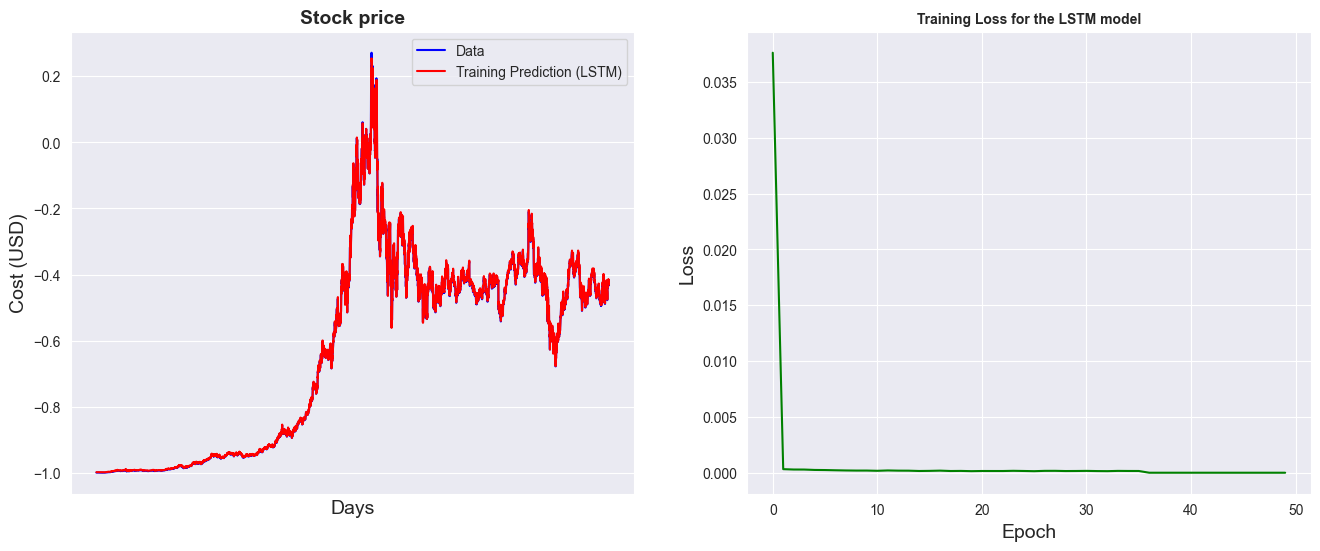

In [26]:
# Visualizing the training prediction
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
original = pd.DataFrame(y_train_lstm.cpu().numpy())
predict = pd.DataFrame(model(x_train).detach().cpu().numpy())
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticks([])
plt.savefig('images/lstm_prediction.png')


# Visualizing the training loss
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss for the LSTM model", size = 10, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig('images/lstm_training_loss.png')

# The training prediction for the LSTM model is really good.

## Evaluate the Model

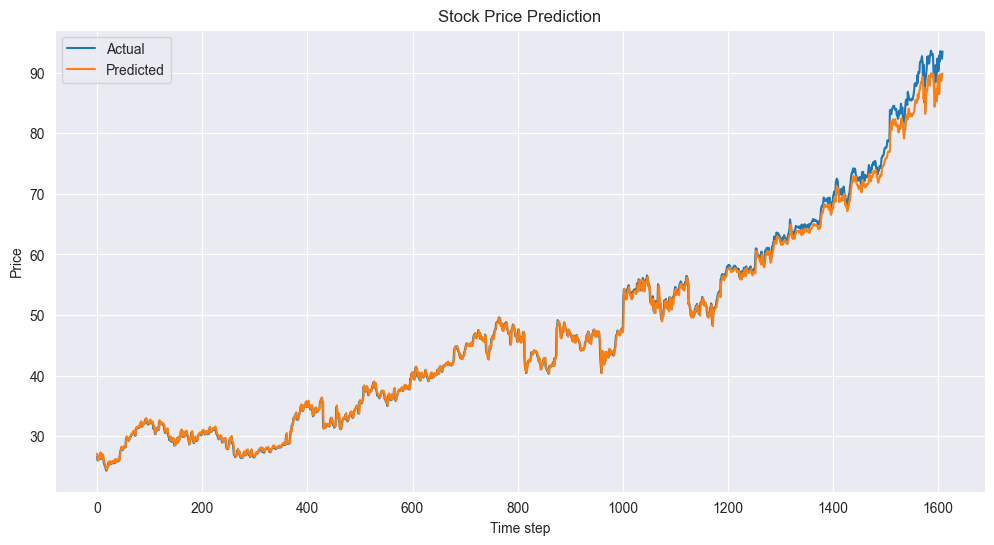

In [27]:
def evaluate_model(model, x_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test)
        true_values = y_test.cpu().numpy()

    # Inverse scale
    predictions_rescaled = scaler.inverse_transform(predictions.cpu().numpy())

    true_rescaled = scaler.inverse_transform(true_values)

    return predictions_rescaled, true_rescaled

predicted, actual = evaluate_model(model, x_test, y_test_lstm, scaler)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.title("Stock Price Prediction")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.legend()
plt.savefig('images/lstm_prediction.png')
plt.show()

# The model was performing better at the training dataset than the test dataset, which is a common issue in machine learning when overfitting occurs.
# LSTM model is composed of a cell, an input gate, an output gate, and a forget gate. This complicated model needs a lot of data to train properly
# If the model is trained on a small dataset (like the one I used here), it can lead to overfitting, where the model learns the training data too well and fails to generalize to new data.

# Results

In [28]:
model.eval()
with torch.no_grad():
    test_predictions = model(x_test)
    test_mse = loss_fn(test_predictions, y_test_lstm).item()


results = pd.DataFrame({
    "Metric": ["Train MSE", "Validation MSE", "Test MSE", "Training Time (s)"],
    "Value": [train_mse, val_mse, test_mse, train_time]
})

In [29]:
print(results)

              Metric      Value
0          Train MSE   0.000138
1     Validation MSE   0.000260
2           Test MSE   0.000571
3  Training Time (s)  68.656904


In [30]:
print("RMSE:", np.sqrt(mean_squared_error(actual, predicted))) # root mean squared error
print("R² Score:", r2_score(actual, predicted)) # coefficient of determination, how well the model explains the variance in the data

RMSE: 1.118013623374685
R² Score: 0.9956445097923279
